## Geoprocessing

In [1]:
import geopandas as gpd

In [2]:
scag = gpd.read_file("data/scag_region.gpkg", layer="tracts")

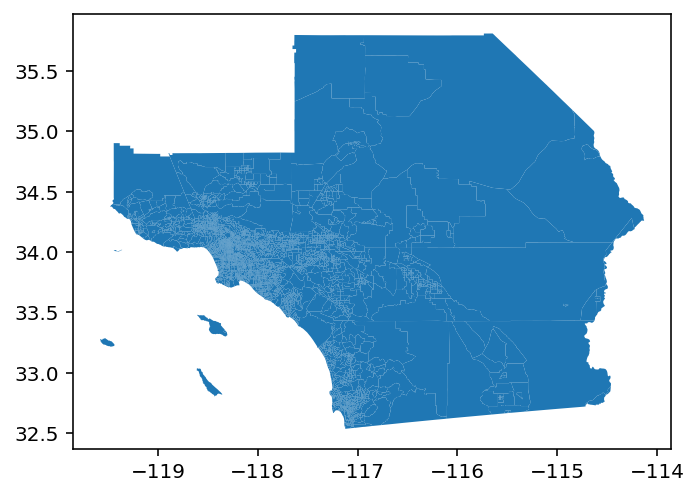

In [3]:
scag.plot()

In [4]:
scag.head()

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry
0,06037128702,58.0,0.0,223.0,0.0,475.0,986.0,None,None,None,...,2010,2903.0,64.726214,None,None,None,None,None,None,"POLYGON ((-118.44870 34.16485, -118.43997 34.1..."
1,06037131600,83.0,62.0,777.0,0.0,135.0,1355.0,None,None,None,...,2010,1487.0,28.679979,None,None,None,None,None,None,"POLYGON ((-118.56229 34.22033, -118.55792 34.2..."
2,06037134104,287.0,17.0,816.0,0.0,61.0,1323.0,None,None,None,...,2010,1388.0,14.846188,None,None,None,None,None,None,"POLYGON ((-118.57976 34.21558, -118.57539 34.2..."
3,06037134304,90.0,24.0,298.0,0.0,89.0,520.0,None,None,None,...,2010,928.0,33.378933,None,None,None,None,None,None,"POLYGON ((-118.61472 34.21952, -118.61039 34.2..."
4,06037242000,0.0,229.0,681.0,0.0,0.0,1164.0,None,None,None,...,2010,1054.0,0.058565,None,None,None,None,None,None,"POLYGON ((-118.25416 33.93882, -118.25413 33.9..."


## Extracting Riverside County Tracts

In [5]:
rc = scag[scag['geoid'].str.match("^06065")]

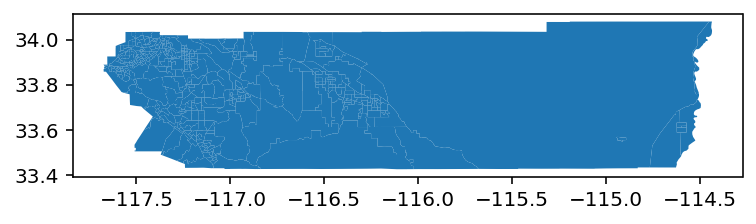

In [6]:
rc.plot()

## Spatial Joins

### Reading a point shapefile

In [7]:
clinics_df = gpd.read_file('data/behavioralHealth.shp')
clinics_df.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry'],
      dtype='object')

In [8]:
clinics_df.shape

(28, 8)

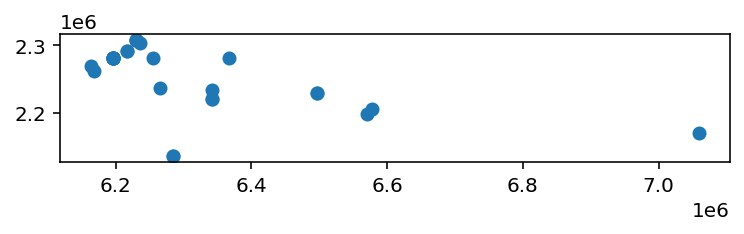

In [9]:
clinics_df.plot()

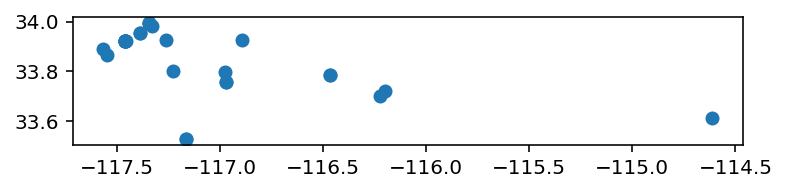

In [10]:
clinics_df.to_crs(rc.crs).plot()

In [11]:
# convert crs of clinics to match that of tracts
clinics_df = clinics_df.to_crs(rc.crs)

In [12]:
clinics_tracts = gpd.sjoin(clinics_df, rc, op='within')

In [13]:
clinics_tracts.head()

,OBJECTID,SITE_TYPE,SITE_NAME,ADDRESS,CITY,ZIPCODE,PHONE,geometry,index_right,geoid,...,n_white_persons,year,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled
0,149.0,Behavioral Health,Older Adult Services,6355 Riverside Ave,Riverside,92506,951-369-0219,POINT (-117.38820 33.95198),661,06065031100,...,None,2010,1715.0,49.159311,None,None,None,None,None,None
25,146.0,Behavioral Health,Adult Mental Health Services - Central Clinic,6355 Riverside Ave,Riverside,92506,951-369-5714,POINT (-117.38819 33.95198),661,06065031100,...,None,2010,1715.0,49.159311,None,None,None,None,None,None
1,150.0,Behavioral Health,Children'S Treatment Services,9990 County Farm Rd,Riverside,92503,951-358-4840,POINT (-117.45675 33.92003),1798,06065041201,...,None,2010,1135.0,25.836431,None,None,None,None,None,None
4,152.0,Behavioral Health,Interagency Services For Families,9890 County Farm Rd,Riverside,92503,951-358-4850,POINT (-117.45548 33.92001),1798,06065041201,...,None,2010,1135.0,25.836431,None,None,None,None,None,None
5,448.0,Behavioral Health,Children'S Evaluation Services Unite,9990 County Farm Rd,Riverside,92503,951-358-7380,POINT (-117.45675 33.92003),1798,06065041201,...,None,2010,1135.0,25.836431,None,None,None,None,None,None


In [14]:
clinics_tracts.shape

(28, 202)

In [15]:
clinics_df.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry'],
      dtype='object')

In [16]:
clinics_tracts.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry', 'index_right', 'geoid',
       ...
       'n_white_persons', 'year', 'n_total_housing_units_sample',
       'p_nonhisp_white_persons', 'p_white_over_60', 'p_black_over_60',
       'p_hispanic_over_60', 'p_native_over_60', 'p_asian_over_60',
       'p_disabled'],
      dtype='object', length=202)

In [17]:
# geoid is now attached to each clinic (i.e., tract identifier)

In [18]:
clinics_tracts[['geoid', 'index_right']].groupby('geoid').agg('count')

,index_right
geoid,
06065031100,2
06065040809,1
06065041201,7
06065041813,1
06065042209,3
06065042210,1
06065042512,1
06065042620,1
06065043507,2


In [19]:
clinics_tracts.groupby(['geoid']).size()

geoid
06065031100    2
06065040809    1
06065041201    7
06065041813    1
06065042209    3
06065042210    1
06065042512    1
06065042620    1
06065043507    2
06065044101    1
06065045000    2
06065045303    1
06065045501    1
06065046102    1
06065049600    2
06065051300    1
dtype: int64

In [20]:
clinics_tracts.groupby(['geoid']).size().reset_index(name='clinics')

,geoid,clinics
0,06065031100,2
1,06065040809,1
2,06065041201,7
3,06065041813,1
4,06065042209,3
5,06065042210,1
6,06065042512,1
7,06065042620,1
8,06065043507,2
9,06065044101,1


In [21]:
twc = clinics_tracts.groupby(['geoid']).size().reset_index(name='clinics')

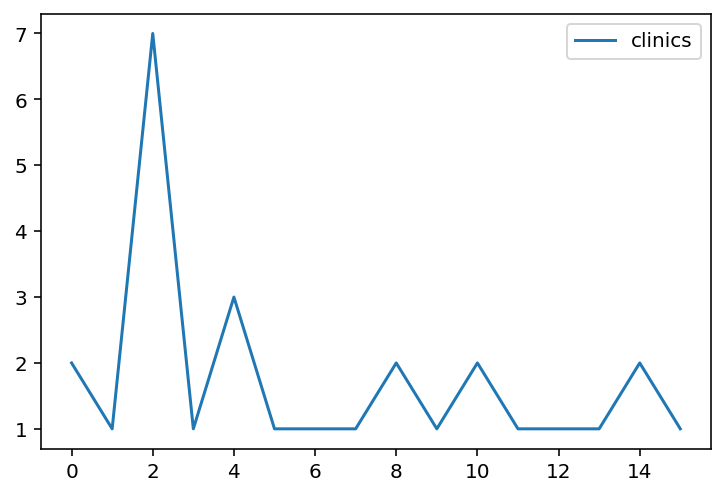

In [22]:
twc.plot()

In [23]:
rc_clinics = rc.merge(twc, how='left', on='geoid')

In [24]:
rc_clinics.head()

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry,clinics
0,06065042005,7.0,157.0,259.0,0.0,540.0,1472.0,None,None,None,...,1511.0,52.240247,None,None,None,None,None,None,"POLYGON ((-117.37448 33.90163, -117.36616 33.9...",NaN
1,06065042210,14.0,4.0,392.0,0.0,49.0,626.0,None,None,None,...,2047.0,26.254459,None,None,None,None,None,None,"POLYGON ((-117.33985 33.98667, -117.33982 33.9...",1.0
2,06065042403,10.0,62.0,604.0,0.0,142.0,1153.0,None,None,None,...,1194.0,27.105703,None,None,None,None,None,None,"POLYGON ((-117.22652 33.95709, -117.21776 33.9...",NaN
3,06065042405,17.0,570.0,877.0,0.0,140.0,1949.0,None,None,None,...,1960.0,12.679643,None,None,None,None,None,None,"POLYGON ((-117.26147 33.94660, -117.25273 33.9...",NaN
4,06065042507,6.0,196.0,1132.0,0.0,47.0,1778.0,None,None,None,...,1209.0,11.965812,None,None,None,None,None,None,"POLYGON ((-117.24366 33.88100, -117.24356 33.8...",NaN


In [25]:
rc_clinics.head()

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry,clinics
0,06065042005,7.0,157.0,259.0,0.0,540.0,1472.0,None,None,None,...,1511.0,52.240247,None,None,None,None,None,None,"POLYGON ((-117.37448 33.90163, -117.36616 33.9...",NaN
1,06065042210,14.0,4.0,392.0,0.0,49.0,626.0,None,None,None,...,2047.0,26.254459,None,None,None,None,None,None,"POLYGON ((-117.33985 33.98667, -117.33982 33.9...",1.0
2,06065042403,10.0,62.0,604.0,0.0,142.0,1153.0,None,None,None,...,1194.0,27.105703,None,None,None,None,None,None,"POLYGON ((-117.22652 33.95709, -117.21776 33.9...",NaN
3,06065042405,17.0,570.0,877.0,0.0,140.0,1949.0,None,None,None,...,1960.0,12.679643,None,None,None,None,None,None,"POLYGON ((-117.26147 33.94660, -117.25273 33.9...",NaN
4,06065042507,6.0,196.0,1132.0,0.0,47.0,1778.0,None,None,None,...,1209.0,11.965812,None,None,None,None,None,None,"POLYGON ((-117.24366 33.88100, -117.24356 33.8...",NaN


In [26]:
rc_clinics.fillna(value=0, inplace=True)

In [27]:
rc_clinics.head()

,geoid,n_asian_under_15,n_black_under_15,n_hispanic_under_15,n_native_under_15,n_white_under_15,n_persons_under_18,n_asian_over_60,n_black_over_60,n_hispanic_over_60,...,n_total_housing_units_sample,p_nonhisp_white_persons,p_white_over_60,p_black_over_60,p_hispanic_over_60,p_native_over_60,p_asian_over_60,p_disabled,geometry,clinics
0,06065042005,7.0,157.0,259.0,0.0,540.0,1472.0,0,0,0,...,1511.0,52.240247,0,0,0,0,0,0,"POLYGON ((-117.37448 33.90163, -117.36616 33.9...",0.0
1,06065042210,14.0,4.0,392.0,0.0,49.0,626.0,0,0,0,...,2047.0,26.254459,0,0,0,0,0,0,"POLYGON ((-117.33985 33.98667, -117.33982 33.9...",1.0
2,06065042403,10.0,62.0,604.0,0.0,142.0,1153.0,0,0,0,...,1194.0,27.105703,0,0,0,0,0,0,"POLYGON ((-117.22652 33.95709, -117.21776 33.9...",0.0
3,06065042405,17.0,570.0,877.0,0.0,140.0,1949.0,0,0,0,...,1960.0,12.679643,0,0,0,0,0,0,"POLYGON ((-117.26147 33.94660, -117.25273 33.9...",0.0
4,06065042507,6.0,196.0,1132.0,0.0,47.0,1778.0,0,0,0,...,1209.0,11.965812,0,0,0,0,0,0,"POLYGON ((-117.24366 33.88100, -117.24356 33.8...",0.0


In [28]:
rc_clinics['clinics'].sum()

28.0

## Extraction of Islands

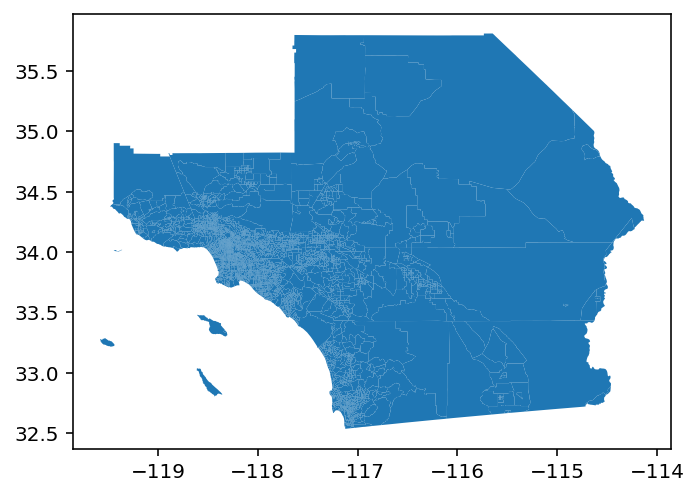

In [29]:
scag.plot()

In [30]:
import libpysal

In [31]:
wq = libpysal.weights.contiguity.Queen.from_dataframe(scag)

/Users/knaaptime/anaconda3/envs/pysal-workshop/lib/python3.7/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 4285.
  warnings.warn(message)


In [32]:
wq.component_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [33]:
import numpy as np

In [34]:
mainland = scag.iloc[wq.component_labels==0]

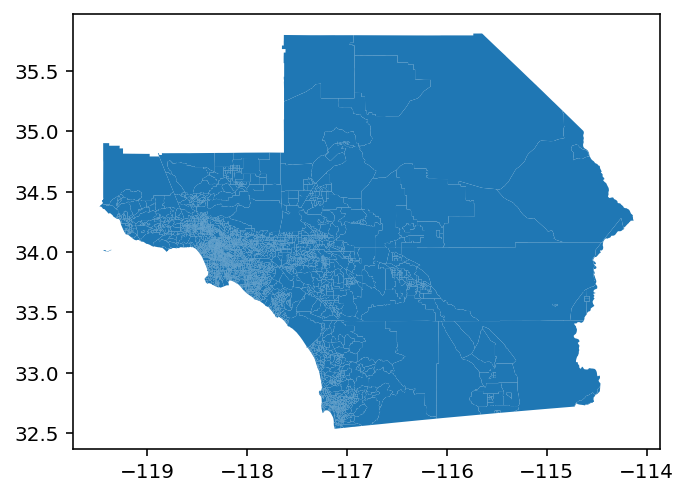

In [35]:
mainland.plot()

In [36]:
mainland.to_file('data/socal.shp')

## Exercise

Create a shapefile for each of the counties in the Southern California dataframe, and write to `data/<code>.shp`.